# Binaural Sound From Surround Sound

 Here we have used MIT's dataset of head-related transfer functions (HRTF) containing measurements of a KEMAR dummy head microphone. Binaural synthesis has been performed on surround sound.

original framerate (in Hz) 16000


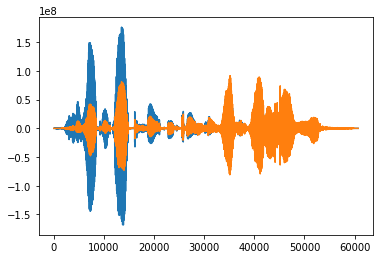

In [115]:
from numpy import *
from scipy import *
from scipy.io import wavfile
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

def make_stereo(filename, sig_l, sig_r, fs=44100):
    sig = array([sig_l, sig_r]).T
    sig = sig / sig.max()
    wavfile.write(filename, fs, (15000*sig).astype(int16))

def read_impulse(elev, azimuth, N=128):
    """ Accepts elev and azimuth in degrees, and returns closest impulse response and transfer function to that combination from compact KEMAR HRTF measurements"""

    elev, azimuth, flip = setangles(elev, azimuth)

    filename = "filters/MIT_KEMAR/full/elev"+str(elev)+"/L"+str(elev)+"e"+str("%03d" % azimuth)+"a.wav"
    fs, h_t_l = wavfile.read(filename)
    filename = "filters/MIT_KEMAR/full/elev"+str(elev)+"/R"+str(elev)+"e"+str("%03d" % (180-azimuth))+"a.wav"
    fs, h_t_r = wavfile.read(filename)
    # print elev,azimuth TODO
    h_t_l = transpose(transpose(h_t_l))
    h_t_r = transpose(transpose(h_t_r))
    if flip:
        return h_t_r, h_t_l
    return h_t_l, h_t_r

def setangles(elev, azimuth):
    elev = int(elev)
    azimuth = int(azimuth)

    #bring to multiple of ten
    if elev != 0:
        while elev%10 > 0:
            elev = elev + 1

    if elev > 90:
        elev = 90
    if elev < -40:
        elev = -40

    #Set increment of azimuth based on elevation
    if abs(elev) < 30:
        incr = 5
    elif abs(elev) == 30:
        incr = 6
    elif abs(elev) == 40:
        incr = 6.43
        opts = [0, 6, 13, 19, 26, 32, 29, 45, 51, 58, 64, 71, 77, 84, 90, 96, 103, 109, 116, 122, 129, 135, 141, 148, 154, 161, 167, 174, 180]
    elif elev == 50:
        incr = 8
    elif elev == 60:
        incr = 10
    elif elev == 70:
        incr = 15
    elif elev == 80:
        incr = 30
    elif elev == 90:
        incr = 0
        azimuth = 0
    flip = False

    #bring into [-pi,pi]
    while azimuth > 180:
        azimuth = azimuth - 180
    while azimuth < -180:
        azimuth = azimuth + 180

    #check if we need to flip left and right.
    if azimuth < 0:
        azimuth = abs(azimuth)
        flip = True

    if abs(elev) == 40:
        incr = 6.43
        num = incr
        while azimuth > num:
            num = num + incr

        #azimuth = str(int(round(num)))
        azimuth = int(round(num))
        #special case for non-integer increment

    elif azimuth != 0:
        while azimuth % incr > 0:
            azimuth = azimuth + 1

    if int(azimuth) < 100:
        azimuth = "0" + str(int(azimuth))

    if int(azimuth) < 10:
        azimuth = "00"+ str(int(azimuth))

    return elev, int(azimuth), flip

def project(sig, elev, azimuth):
    h_t_l, h_t_r = read_impulse(elev, azimuth)

    Hw_l = fft(h_t_l, len(sig))
    Hw_r = fft(h_t_r, len(sig))

    f_diner = fft(sig)
    f_diner_l = Hw_l*f_diner
    f_diner_r = Hw_r*f_diner
    t_diner_l = ifft(f_diner_l, len(sig))
    t_diner_r = ifft(f_diner_r, len(sig))
    #t_diner_l = fftpack.convolve.convolve(sig, h_t_l)
    #t_diner_r = fftpack.convolve.convolve(sig, h_t_r)
    #print "dtype of t_diner_l in project", t_diner_l.dtype
    return t_diner_l, t_diner_r


def path(t_sig, start, end, duration=0, window_size=1024, fs=44100):
    """ Moves a sound from start to end positions over duration (Seconds)"""
    
    M = (fs/2) / window_size
    w = r_[:fs/2:M]
    N = len(w)
    #print(len(w))
    #window = hamming_window(N)(r_[:window_size])
    window = hamming(N)#(r_[:window_size])
    #window = cut_gaussian(N) # TODO
    #window = sinc_times_gaussian(N) # TODO
    #print(window.shape)
    #print(window)
    i = 1
    elev = start[0]
    elev_end = end[0]

    if duration == 0:
        duration = len(t_sig)/fs

    azimuth = start[1]
    azimuth_end = end[1]
    N_steps = int(len(t_sig) * 2 / window_size)
    elev_delta = float((elev_end - elev) / float(N_steps)) #deg/half-window
    azimuth_delta = float((azimuth_end - azimuth) / float(N_steps))

    output_l = zeros( len(t_sig) )
    output_r = zeros( len(t_sig) )

    while i*(window_size) < len(t_sig):
        ind_min = int((i-1.)*window_size)
        ind_max = int((i)*window_size)
        t_sig_w = t_sig[ind_min:ind_max] * window        
        t_output_l, t_output_r = project(t_sig_w, elev, azimuth)
        output_l[ind_min:ind_max] =output_l[ind_min:ind_max] + t_output_l
        output_r[ind_min:ind_max]= output_r[ind_min:ind_max] + t_output_r
        elev = elev + elev_delta
        azimuth = azimuth + azimuth_delta
        i = i + 0.5
    return output_l, output_r

def inverse_transfer_function(Hw):
    max_Hw = max(Hw)

    inv_Hw = (Hw + 1./max_Hw ) ** -1
    return inv_Hw

fs, t_diner = wavfile.read('wav/sa1.wav')
#print(t_diner)
#fs, t_diner2 = wavfile.read('wav/sa2.wav')
print("original framerate (in Hz)", fs)

t_diner_l, t_diner_r = path(t_diner, (0, -70), (0, 70), 0, fs/10., fs)
t_diner_l2, t_diner_r2 = path(t_diner2, (0,70), (0, -70), 0, fs/10., fs)

final_l = t_diner_l # TODO longest of the two
#final_l[:len(t_diner_l2)] += t_diner_l2
final_r = t_diner_r
#final_r[:len(t_diner_r2)] += t_diner_r2
make_stereo('wav/360_headphone.wav', final_l, final_r, fs)
plt.plot(final_l)
plt.plot(final_r)
plt.savefig("fig/test.png")
